<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°, 45°, 135°, 225°, and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



# Basic definitions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import wind
import windWT as wt
import windCAD
import windCodes

import winsound

### Files and directories

In [4]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/gable27deg/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

if not os.path.exists(outputDir):
    os.makedirs(outputDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)


### General parameters

In [5]:
saveFigs = True
exposure = 'E2'
cases = 'c2'

caseName_iso_OP = 'nrcNBc2E2'
casedir_iso_OP = rawHFPIdir+caseName_iso_OP+r"/"

caseName_iso_SU = 'nrcNBc2E3'
casedir_iso_SU = rawHFPIdir+caseName_iso_SU+r"/"

caseName_sur_OP = 'nrcNBc1E2'
casedir_sur_OP = rawHFPIdir+caseName_sur_OP+r"/"

caseName_sur_SU = 'nrcNBc1E3'
casedir_sur_SU = rawHFPIdir+caseName_sur_SU+r"/"

profileDir = rawVelDir 

### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

# Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [92]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl/vScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = []

print("lScl = {:.5f}".format(lScl))
print("tScl = {:.5f}".format(tScl))
print("vScl = {:.5f}".format(vScl))

lScl = 0.01000
tScl = 0.02780
vScl = 0.35971


### Basics of faces

In [7]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [-83.05, 79.6967], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1b = [[-55.6, 0], [-83.05, 24.6713], [-83.05, 79.6967], [51.85, 79.6967], [51.85, 24.6713], [31.3, 0], [-55.6, 0], ]
# vertices_face_1c = [[72.4, 0], [51.85, 24.6713], [51.85, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], ]

vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]


### Zone dictionary

In [8]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [72.4, 0, ], [51.85, 24.6713, ], 
                                                [31.3, 0, ], [-55.6, 0, ], [-83.05, 24.6713, ], [-110.5, 0, ], [-193.38, 0, ], ])],
        }

zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### Face objects

Processing face 1...
Generating tributaries ...
Shape of bound: (5, 2)
Shape of coords: (154, 2)
Shape of inftyTribs: (154,)
Shape of tribs: (154,)


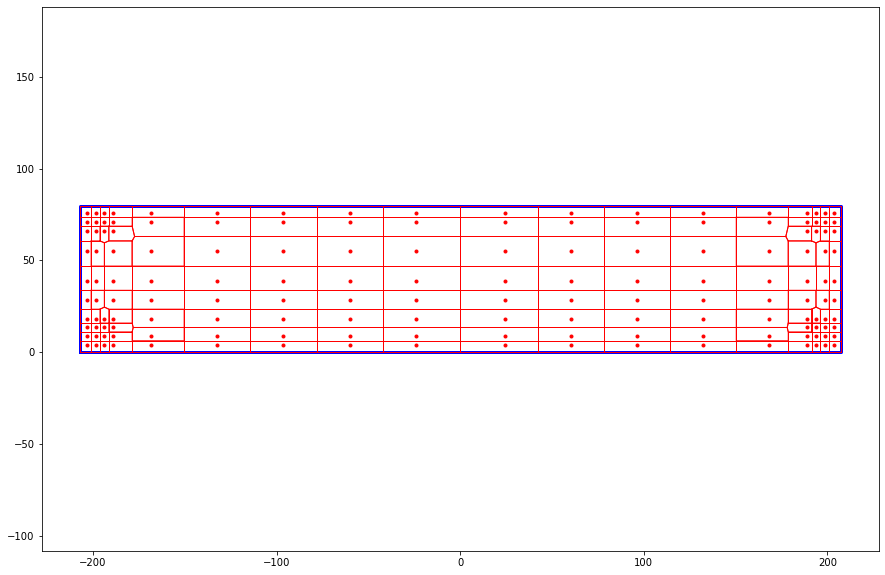

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Reached the limit of wiggle factor of 1.5. Breaking the loop.


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
  

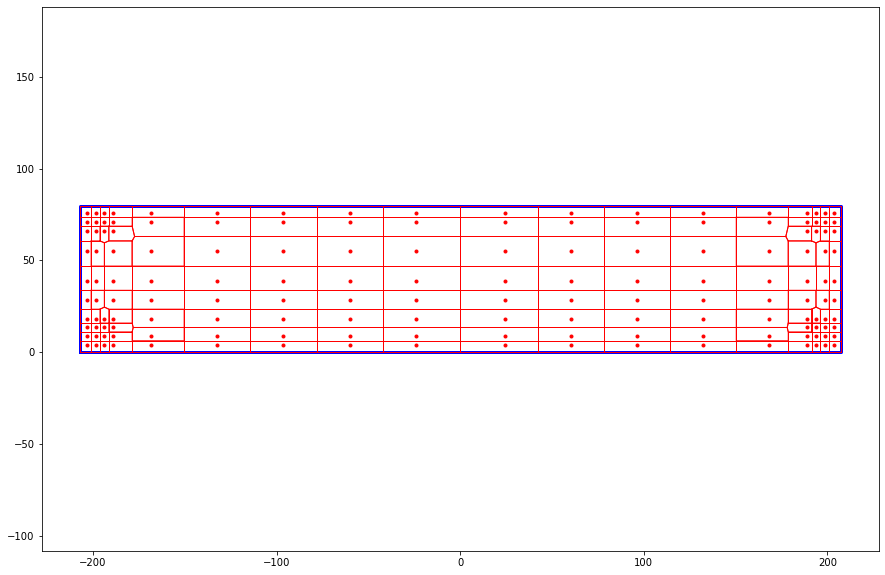

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Reached the limit of wiggle factor of 1.5. Breaking the loop.


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
  

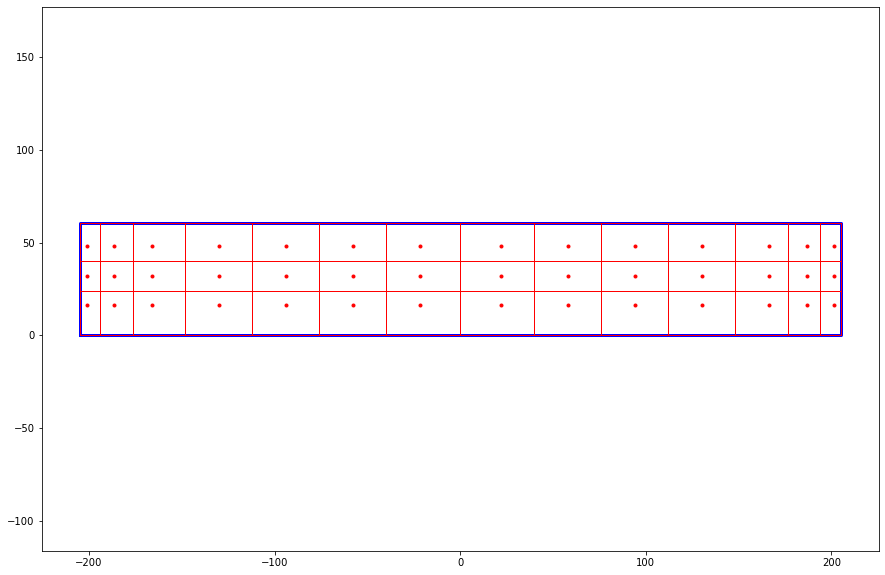

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 3 done.



Processing face 4...
Generating tributaries ...
Shape of bound: (6, 2)
Shape of coords: (24, 2)
Shape of inftyTribs: (24,)
Shape of tribs: (24,)


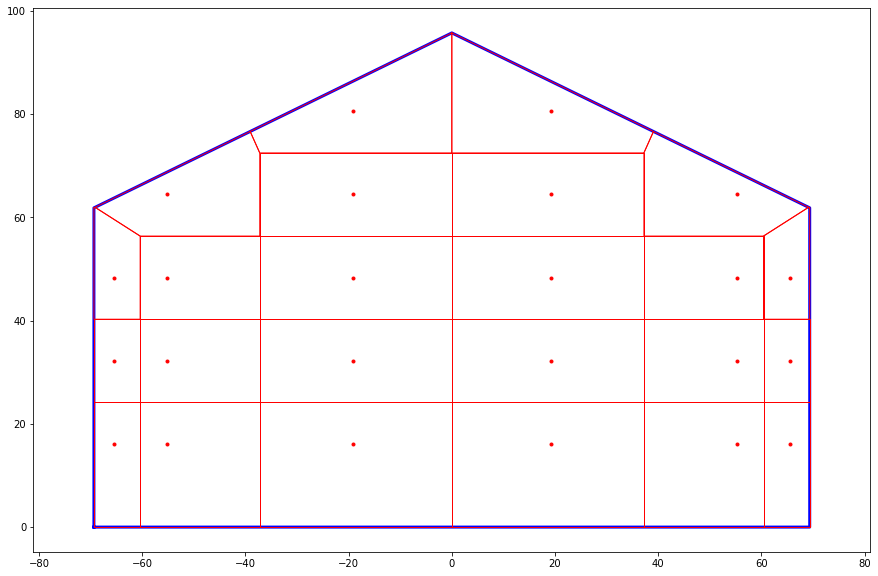

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 4 done.



Processing face 5...
Generating tributaries ...
Shape of bound: (5, 2)
Shape of coords: (42, 2)
Shape of inftyTribs: (42,)
Shape of tribs: (42,)


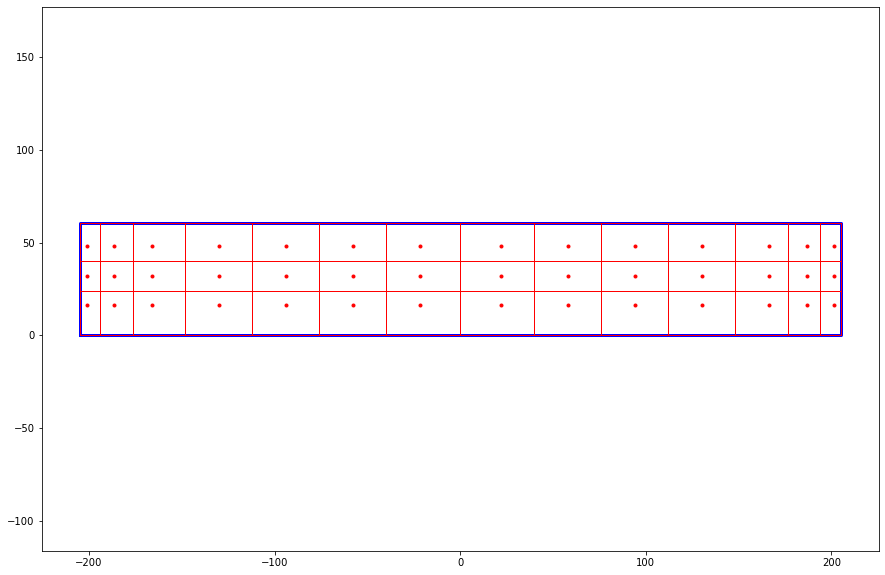

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 5 done.



Processing face 6...
Generating tributaries ...
Shape of bound: (6, 2)
Shape of coords: (24, 2)
Shape of inftyTribs: (24,)
Shape of tribs: (24,)


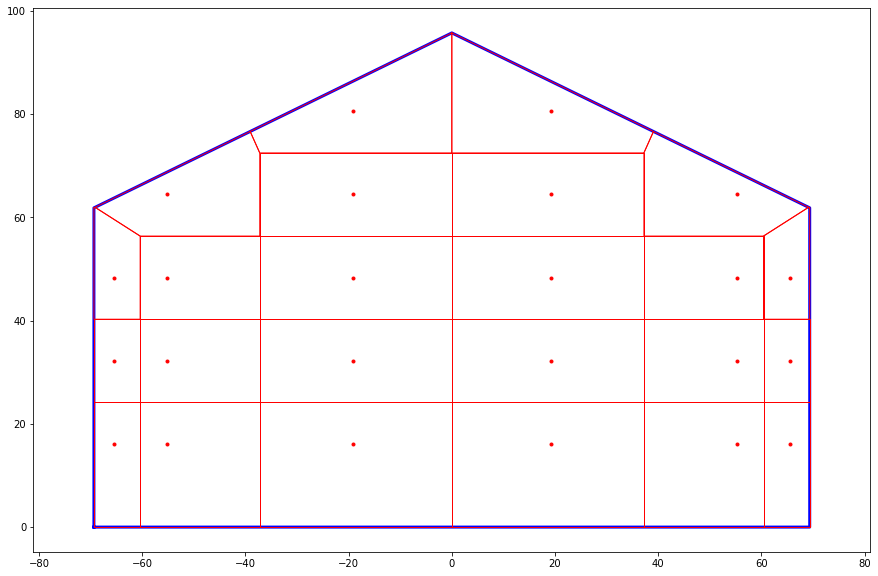

Generating panels ...
Shape of tapTribs: ()
Shape of nominalPanelAreas: (6,)


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 6 done.





In [42]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                showDetailedLog=True,
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Generating tributaries ...
Shape of bound: (5, 2)
Shape of coords: (154, 2)
Shape of inftyTribs: (154,)
Shape of tribs: (154,)


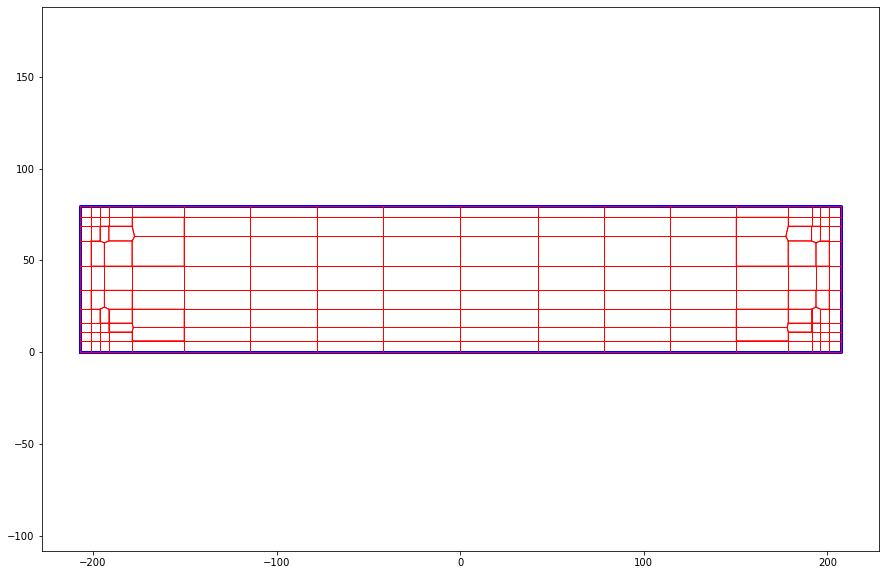

In [38]:
from shapely.ops import voronoi_diagram
import shapely as shp
from shapely.geometry import Polygon

bound = np.array(vertices_basic[0])
idx = tapData.index[tapData.faceID == 1]
tapCrds = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))

inftyTribs = windCAD.trimmedVoronoi(bound, tapCrds, showLog=True)

# # Plot the voronoi diagram
# fig, ax = plt.subplots(figsize=(20,10))
# ax.set_aspect('equal')
# # ax.set_xlim(bound[:,0].min(), bound[:,0].max())
# # ax.set_ylim(bound[:,1].min(), bound[:,1].max())
# # ax.plot(bound[:,0], bound[:,1], 'k-')
# ax.plot(tapCrds[:,0], tapCrds[:,1], 'k.')
# for i in range(len(inftyTribs.geoms)):
#     ax.plot(*inftyTribs.geoms[i].exterior.xy, 'r-')


In [55]:
i = 0
z = faceID[i]
idx = tapData.index[tapData.faceID == z]
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [414, 415, 606, 614, 615]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=f'Face {z} ('+name[i]+' with portico)',
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )

i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 
                2511, 2512, 2513, 2514, 2515, 2516, 2601, 2602, 
                2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 
                2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2515, 2516, 
                2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 
                2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)
print(idx)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5b = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 
                2601, ]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5c = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:181: UserWarning: Type of tributary 79 is <class 'shapely.geometry.multipolygon.MultiPolygon'>. There is a risk of voronoi not completely tiling the bound.
  temp.appen

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Reached the limit of wiggle factor of 1.5. Breaking the loop.


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\Ph

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
  

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Int64Index([392, 393, 394, 395, 396, 397], dtype='int64')
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Generating panels ...
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
    

### Building objects

In [56]:
bldg_iso = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName='Case 2 [x]',
                notes_Cp='Generic isolated case.',
                badTaps=badTaps,
                )

bldg_sur = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[face_1a, faces[1], faces[2], faces[3], face_5a, face_5b, face_5c, faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName='Case 1 {x]',
                notes_Cp='Field case with the porticos and surrounding.',
                badTaps=badTaps,
                )

Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].

Refreshing Case 1 {x]...
Verifying data ...
Done refreshing Case 1 {x].



### Geometry plots

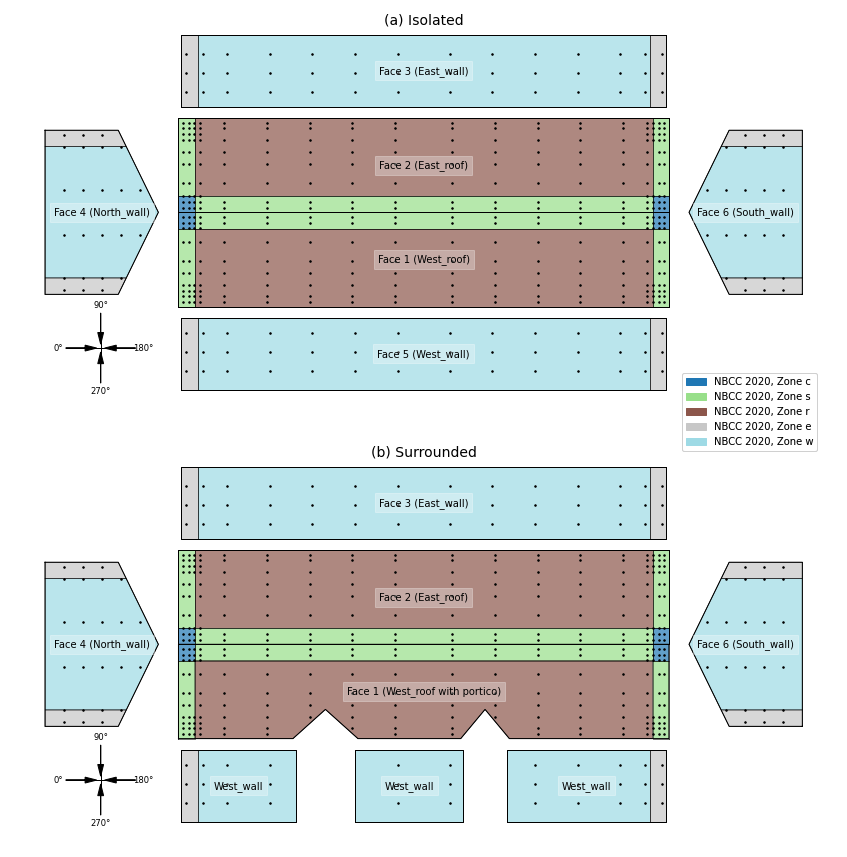

In [61]:
fig = plt.figure(figsize=[12,12])
axs = fig.subplots(2,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs[0]
ax.text(0.5, 0.95, '(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
# bldg_iso.plotTribs(ax=ax,)
_, legend, _ = bldg_iso.plotZones(ax=ax)
ax.add_artist(legend)
legend.set_bbox_to_anchor((0.81, 0.11))
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

ax = axs[1]
ax.text(0.5, 0.95, '(b) Surrounded', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_sur.plotEdges(ax=ax,showName=True)
bldg_sur.plotTaps(ax=ax,showTapNo=False)
# bldg_sur.plotTribs(ax=ax,)
bldg_sur.plotZones(ax=ax, showLegend=False)
bldg_sur.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

plt.show()

# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')


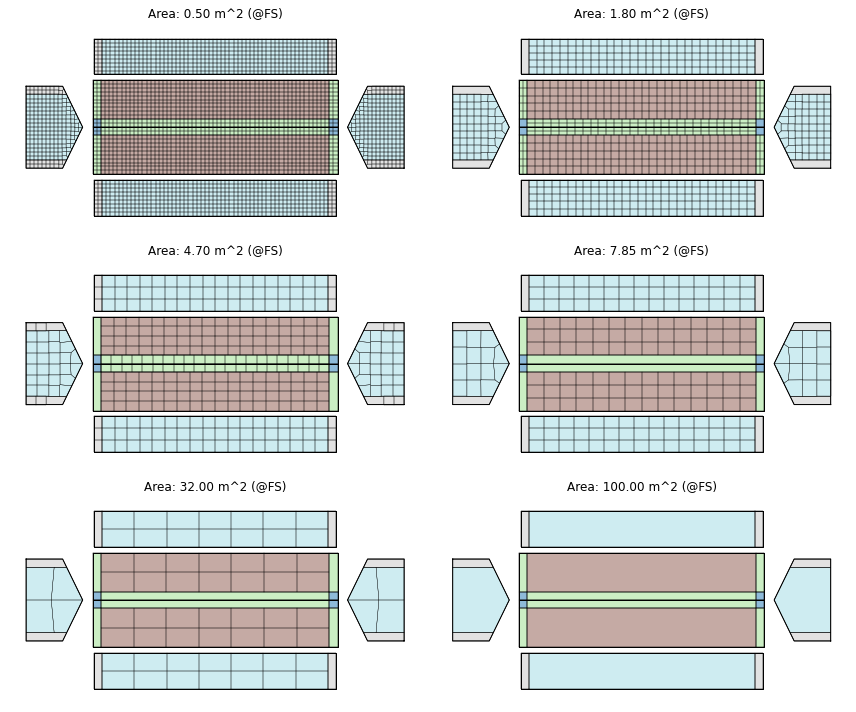

In [60]:
fig, axs = bldg_iso.plotPanels_AllAreas(figsize=[12,10], nCols=2,
    areaUnit='m^2 (@FS)', areaFactor=areaFactor_toFSm2, areaFmt='{:2.2f}',
    kwargs_zoneEdge={'color':'k', 'linewidth':0.3}
    )
# if saveFigs:
#     fig.savefig(figDir+"nominalPanelAreas.svg",format='svg',dpi=1200, bbox_inches='tight')

# Load and process data

## Field data

In [62]:
fieldDataDir = r"D:\tempData_depot\NRC_data\NB_output_final/"
fieldDataFile = fieldDataDir+'NewBrunswick_forPaper1_Stats.xlsx'
figDir2 = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\NRC_fieldMonitoring\NRC_Docs\reports\figures/"

fs_vel = pd.read_excel(fieldDataFile, sheet_name='Velocity', header=0, index_col=0)

fs_meanCp = pd.read_excel(fieldDataFile, sheet_name='meanCp', header=0, index_col=0)

fs_minPeakCp = pd.read_excel(fieldDataFile, sheet_name='minPeakCp', header=0, index_col=0)

fs_maxPeakCp = pd.read_excel(fieldDataFile, sheet_name='maxPeakCp', header=0, index_col=0)

print(np.shape(fs_meanCp))

AoA = fs_vel['AoA [deg]'] - 5.0  # correct for the 5 deg offset in the field data
refH = 1.0

fs_data = {}
fs_data['mean'] = fs_meanCp.to_numpy()
fs_data['peakMin'] = fs_minPeakCp.to_numpy()
fs_data['peakMax'] = fs_maxPeakCp.to_numpy()

H_FS = 9.81

z0=1.0
es85_Fld = wind.ESDU85(z0=z0)
es85_Fld_obj = es85_Fld.toProfileObj()
es85_Fld_obj.name = r'ESDU ($z_0='+f"{z0:.2g}"+'m$)'
es85_Fld_obj.SpectH.name = r'ESDU ($z_0='+f"{z0:.2g}"+'m$)'

N_rows = fs_vel.shape[0]

U = fs_vel['U [m/s]'].to_numpy()
fieldData = {
    'name': 'Field measurements',
    'AoA':  AoA.to_numpy(),
    'Z':    [1.0],
    'U':    np.ones(N_rows),
    'U_orig': fs_vel['U [m/s]'].to_numpy(),
    'Iu':   fs_vel['Iu'].to_numpy(),
    'Iv':   fs_vel['Iv'].to_numpy(),
    'Iw':   fs_vel['Iw'].to_numpy(),
    'xLu':  fs_vel['xLu [m]'].to_numpy()/H_FS,
    'xLv':  fs_vel['xLv [m]'].to_numpy()/H_FS,
    'xLw':  fs_vel['xLw [m]'].to_numpy()/H_FS,
    'uw':   fs_vel['uw [(m/s)^2]'].to_numpy()/U**2,
    'uv':   fs_vel['uv [(m/s)^2]'].to_numpy()/U**2,
    'vw':   fs_vel['vw [(m/s)^2]'].to_numpy()/U**2,
}
print(np.shape(fieldData['Z']))

(45, 15)
(1,)


In [63]:
import scipy.io as sio

spectFile = fieldDataDir+'Spect_for_python.mat'
print(spectFile)
spectData = sio.loadmat(spectFile)

print(spectData.keys())
fieldData['n'] = np.squeeze(spectData['f'])
fieldData['Suu'] = np.squeeze(spectData['Suu'])
fieldData['Svv'] = np.squeeze(spectData['Svv'])
fieldData['Sww'] = np.squeeze(spectData['Sww'])
fieldData['rf'] = np.squeeze(spectData['rf'])
fieldData['rSuu'] = np.squeeze(spectData['rSuu'])
fieldData['rSvv'] = np.squeeze(spectData['rSvv'])
fieldData['rSww'] = np.squeeze(spectData['rSww'])

fieldData['rf_avg'] = np.mean(fieldData['rf'], axis=1)
fieldData['rSuu_avg'] = np.mean(fieldData['rSuu'], axis=1)
fieldData['rSvv_avg'] = np.mean(fieldData['rSvv'], axis=1)
fieldData['rSww_avg'] = np.mean(fieldData['rSww'], axis=1)

idx = np.where((fieldData['AoA'] >= 255) & (fieldData['AoA'] < 285))[0]
fieldData_West = fieldData.copy()
keys = ['AoA', 'U', 'U_orig', 'Iu', 'Iv', 'Iw', 'xLu', 'xLv', 'xLw', 'uw', 'uv', 'vw']
for k in keys:
    fieldData_West[k] = fieldData_West[k][idx]
fieldData_West['rf'] = fieldData_West['rf'][:,idx]
fieldData_West['rSuu'] = fieldData_West['rSuu'][:,idx]
fieldData_West['rSvv'] = fieldData_West['rSvv'][:,idx]
fieldData_West['rSww'] = fieldData_West['rSww'][:,idx]
fieldData_West['Suu'] = fieldData_West['Suu'][:,idx]
fieldData_West['Svv'] = fieldData_West['Svv'][:,idx]
fieldData_West['Sww'] = fieldData_West['Sww'][:,idx]
fieldData_West['rf_avg'] = np.mean(fieldData_West['rf'], axis=1)
fieldData_West['rSuu_avg'] = np.mean(fieldData_West['rSuu'], axis=1)
fieldData_West['rSvv_avg'] = np.mean(fieldData_West['rSvv'], axis=1)
fieldData_West['rSww_avg'] = np.mean(fieldData_West['rSww'], axis=1)

print(np.shape(fieldData['n']))
print(np.shape(fieldData['Suu']))
print(np.shape(fieldData_West['rf']))

D:\tempData_depot\NRC_data\NB_output_final/Spect_for_python.mat
dict_keys(['__header__', '__version__', '__globals__', 'Suu', 'Svv', 'Sww', 'f', 'rSuu', 'rSvv', 'rSww', 'rf'])
(1025,)
(1025, 45)
(1025, 23)


## Wind tunnel


### Wind field

In [64]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [65]:
# if exp == 'E2':
#     vel_WT = vel_OP
# elif exp == 'E3':
#     vel_WT = vel_SU
z0_OP = 0.02
z0_SU = 0.2

es85_OP = wind.ESDU85(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_OP = wind.ESDU74(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E2_ESDU = es85_OP.toProfileObj()
vel_E2_ESDU.SpectH = es74_OP.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'

es85_SU = wind.ESDU85(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_SU = wind.ESDU74(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E3_ESDU = es85_SU.toProfileObj()
vel_E3_ESDU.SpectH = es74_SU.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'

# vel = wind.Profiles([vel_OP, vel_SU, es74_OP.toProfileObj(), es85_OP.toProfileObj(), es74_SU.toProfileObj(), es85_SU.toProfileObj(),])
vel = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU,])
vel_OP_all = wind.Profiles([vel_OP, es74_OP.toProfileObj(), es85_OP.toProfileObj(),])
vel_SU_all = wind.Profiles([vel_SU, es74_SU.toProfileObj(), es85_SU.toProfileObj(),])

### Pressure

In [66]:
analogChannels_idxs={
                'main_pitot': 0,
                'xcheck_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [67]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_iso_OP = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                caseName=caseName_iso_OP,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                notes_Cp=cp_raw.description,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_iso_SU = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                caseName=caseName_iso_SU,
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)


Reading HFPI data from: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P001a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P002a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P003a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P004a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P005a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P006a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P007a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P008a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P009a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P010a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R0

In [68]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_sur_OP = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                caseName=caseName_sur_OP,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_sur_SU = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                caseName=caseName_sur_SU,
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

Reading HFPI data from: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P001a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P002a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P003a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P004a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P005a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P006a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P007a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P008a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P009a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P010a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R0

# Plot results

### Field data only

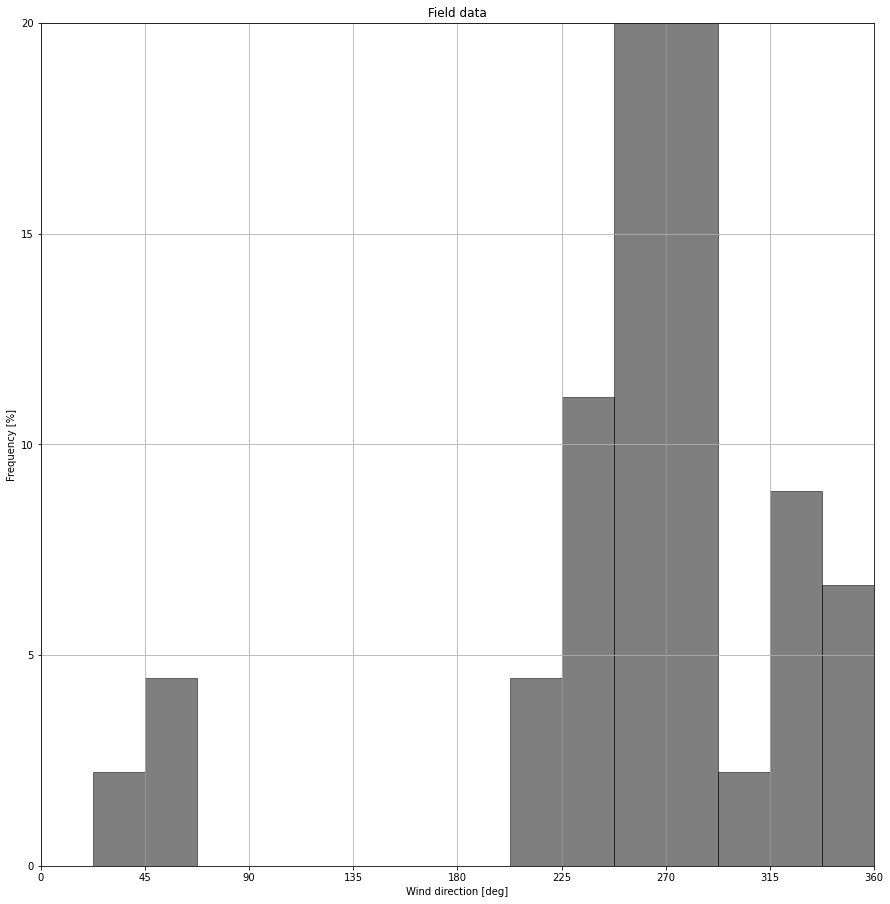

In [69]:
# plot wind rose of the field data using circular bins
fig = plt.figure(figsize=[12,12])
ax = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

nBins = 16
binEdges = np.linspace(0,360,nBins+1)
binCenters = (binEdges[1:] + binEdges[:-1])/2
binWidth = binEdges[1] - binEdges[0]
binCounts = np.zeros(nBins)
for i in range(nBins):
    idx = np.where((AoA >= binEdges[i]) & (AoA < binEdges[i+1]))[0]
    binCounts[i] = len(idx)
binCounts = binCounts/np.sum(binCounts)*100

ax.bar(binCenters, binCounts, width=binWidth, color='k', edgecolor='k', alpha=0.5)  
ax.set_xlim([0,360])
ax.set_ylim([0,20])
ax.set_xticks(np.arange(0,361,45))
ax.set_yticks(np.arange(0,21,5))
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel('Frequency [%]')
ax.set_title('Field data')
ax.grid(True)

### Wind field
#### All profiles

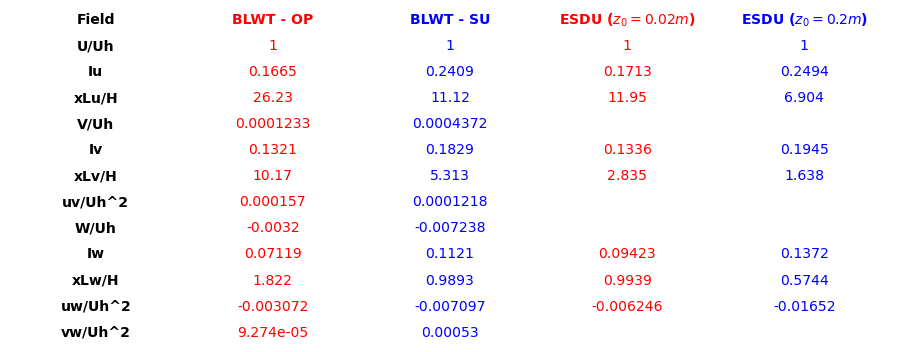

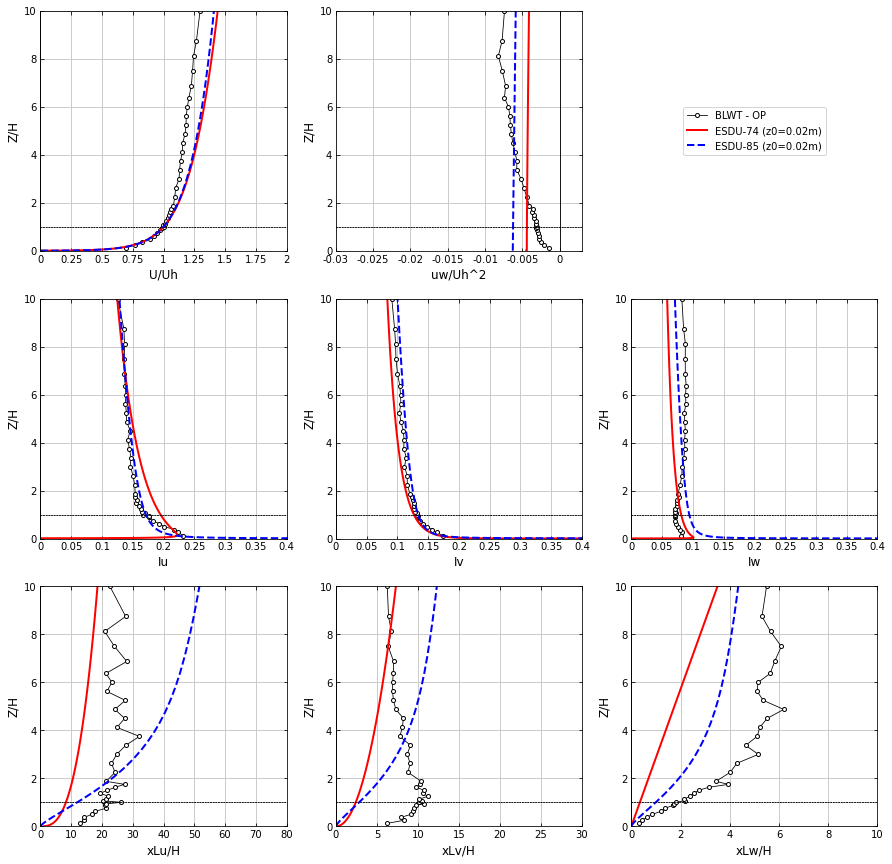

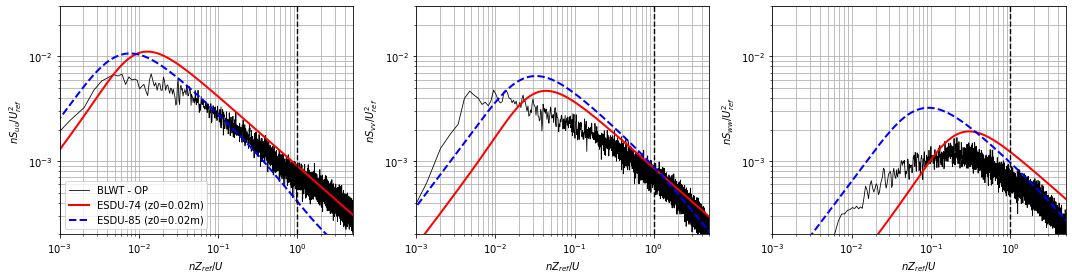

In [71]:
fig, _ = vel.plotRefHeightStatsTable(fontSz=14,figWidthFctr=0.9,
                                     colTxtColors=['r','b','r','b','b','c','r','b','c'],)
# fig.savefig(direct+'kate_refHeightStatsTable.svg', dpi=300, bbox_inches='tight')

kwargs_plt=[{'lw':0.8, 'ls':'-', 'color':'k', 'marker':'o', 'ms':4, 'mfc':'w', }, 
            # {'lw':0.8, 'ls':'-', 'color':'b', 'marker':'d', 'ms':4, 'mfc':'w', },
            {'lw':2, 'ls':'-', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'-', 'color':'c'},
            {'lw':2, 'ls':'--', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'--', 'color':'c'},
            ]

fig, _ = vel_OP_all.plotProfile_basic2(figsize=[15,15],
                        yLimits=[0,10],
                        xLimits_U=[0, 2], xLimits_uw=[-0.03, 0.003],
                        xLimits_Iu=[0,0.4], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.4],
                        xLimits_xLu=[0, 80], xLimits_xLv=[0,30], xLimits_xLw=[0,10],
                        kwargs_plt=kwargs_plt,
                        )
# fig.savefig(direct+'kate_profile_basic2.svg', dpi=300, bbox_inches='tight')

kwargs_sp_plt=[ {'lw':0.8, 'ls':'-', 'color':'k', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                # {'lw':0.8, 'ls':'--', 'color':'b', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                {'lw':2, 'ls':'-', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'-', 'color':'c'},
                {'lw':2, 'ls':'--', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'--', 'color':'c'},
                ]
fig = vel_OP_all.plotSpectra(figsize=[15,4], xLimits=[1e-3,5],
                yLimits=[[2e-4,3e-2],[2e-4,3e-2],[2e-4,3e-2]],
                kwargs_plt=kwargs_sp_plt,)
# fig.savefig(direct+'kate_spectra.svg', dpi=300, bbox_inches='tight')

#### Selected profiles and spectra

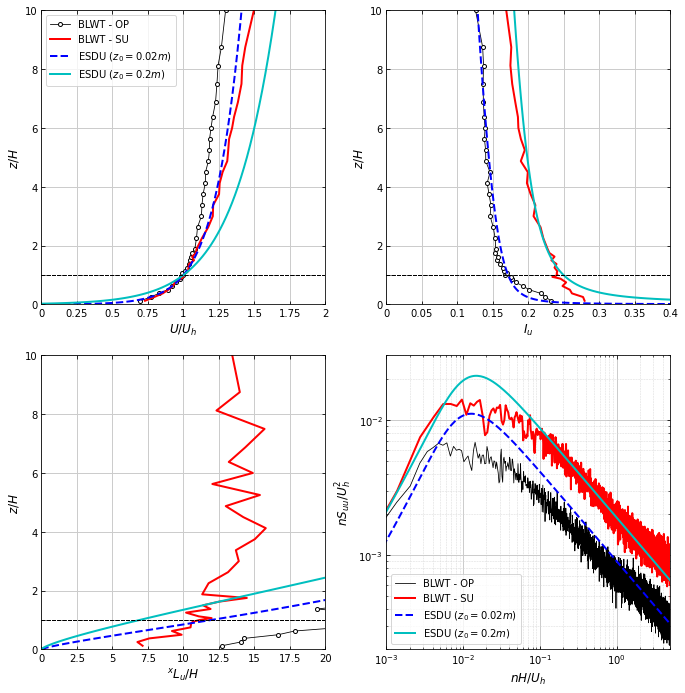

In [62]:
fig, axs = plt.subplots(2,2,figsize=[10,10])
# tight_layout
fig.tight_layout(pad=3.0)

def custom_format(x, pos):
    return f"{x:g}"  # Format the value with 2 decimal places and add ° symbol

kwargs_hline = {'color':'k', 'lw':1.0, 'ls':'--'}
for i, prof in enumerate(vel.profiles):
    ax = axs[0,0]
    ax.plot(prof.UbyUh, prof.ZbyH, label=prof.name, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.legend()
    ax.set_xlabel(r'$U/U_h$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,2])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[0,1]
    ax.plot(prof.Iu, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$I_u$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,0.4])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,0]
    ax.plot(prof.xLuByH, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$^xL_u/H$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,20])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,1]
    ax.loglog(prof.SpectH.rf(), prof.SpectH.rSuu(), label=prof.name, **kwargs_sp_plt[i])
    ax.legend()
    ax.set_xlabel(r'$nH/U_h$')
    ax.set_ylabel(r'$nS_{uu}/U_h^2$')
    ax.set_xlim([1e-3,5])
    ax.set_ylim([2e-4,3e-2])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True, numFormat='default')

plt.show()
# fig.savefig(direct+'kate_concise.svg', dpi=300, bbox_inches='tight')

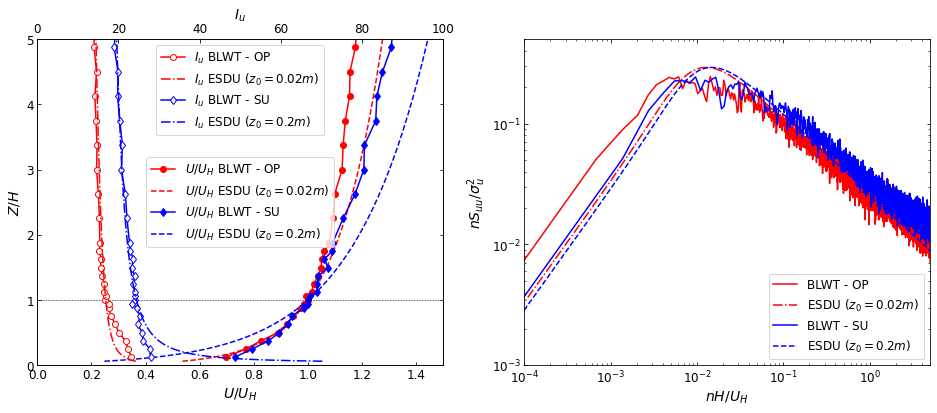

In [18]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

#### WT vs. Field vs. ESDU

Figure saved to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/profile_basic2.svg


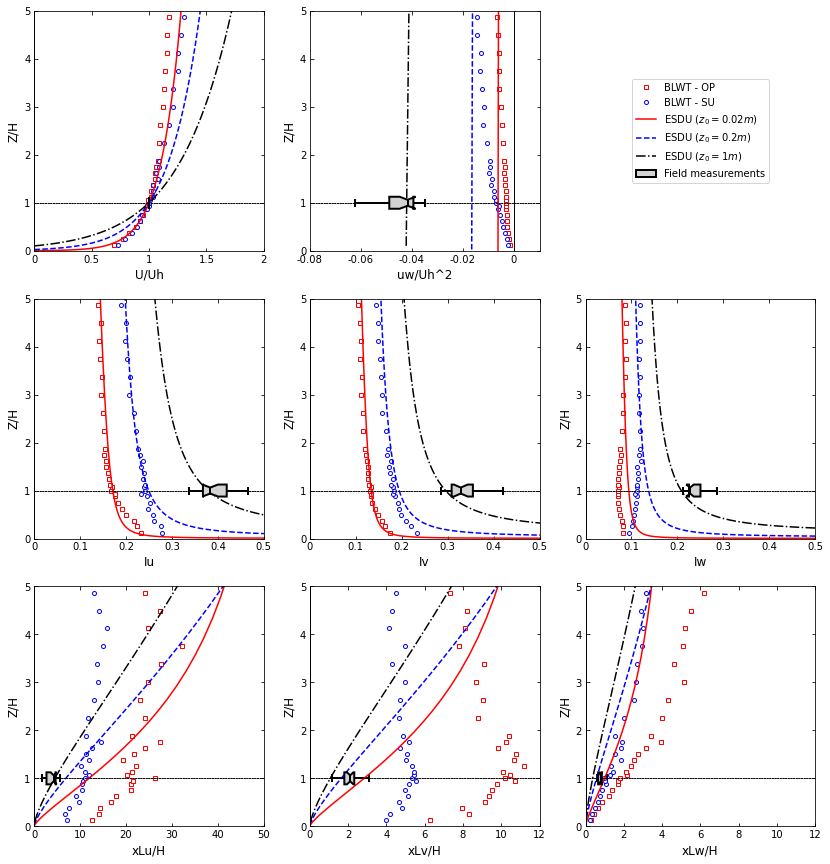

In [72]:
profs = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU, es85_Fld_obj, ])

fig, axs = profs.plotProfile_basic2(figsize=[14,15],
            yLimits=[0,5],
            xLimits_U=[0, 2], xLimits_uw=[-0.08, 0.01], 
            xLimits_Iu=[0,0.5], xLimits_Iv=[0,0.5], xLimits_Iw=[0,0.5], 
            xLimits_xLu=[0, 50], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
            kwargs_plt=[{'color': 'r', 'linewidth':0.5, 'linestyle': 'None',    'marker': 's', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':0.5, 'linestyle': 'None',    'marker': 'o', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.5, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            overlayThese=fieldData_West, overlayType='errorBars', 
            kwargs_overlay = {'widths': 0.25,
                                'notch': True,
                                'vert': False,
                                'showfliers': False,
                                'patch_artist': True,
                                'meanline': True,
                                'boxprops': dict(facecolor='lightgray', color='k', linewidth=2, edgecolor='r'),
                                'medianprops': dict(color='k', linewidth=2),
                                'whiskerprops': dict(color='k', linewidth=2),
                                'capprops': dict(color='k', linewidth=2),
                                },
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
if saveFigs:
    fig.savefig(figDir+"profile_basic2.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Figure saved to {figDir}profile_basic2.svg")
    

In [ ]:
print(fieldData.keys())
print(np.shape(fieldData['rSuu']))


dict_keys(['name', 'AoA', 'Z', 'U', 'Iu', 'Iv', 'Iw', 'xLu', 'xLv', 'xLw', 'uw', 'uv', 'vw', 'n', 'Suu', 'Svv', 'Sww', 'rf', 'rSuu', 'rSvv', 'rSww', 'rf_avg', 'rSuu_avg', 'rSvv_avg', 'rSww_avg'])
(1025, 45)


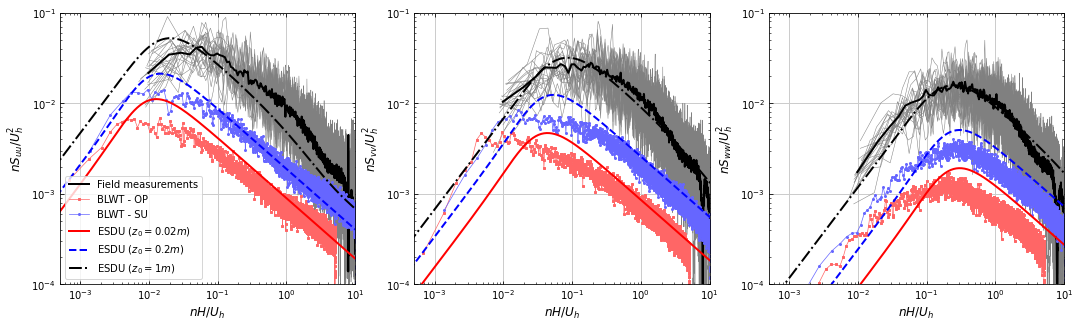

In [73]:
clb = 0.4
r = [1.0, clb, clb, 1.0]
b = [clb, clb, 1.0, 1.0]
kwargs_plt=[{'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 's', 'markersize':2},
            {'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 'o', 'markersize':2},
            {'color': 'r', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'b', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'k', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            ]

fig = profs.plotSpect(figsize=[18,5], xLimits=[5e-4, 1e1], yLimits=[[1e-4,1e-1],[1e-4,1e-1],[1e-4,1e-1]],
                      xLabel=r'$nH/U_h$', yLabel_Suu=r'$nS_{uu}/U_h^2$', yLabel_Svv=r'$nS_{vv}/U_h^2$', yLabel_Sww=r'$nS_{ww}/U_h^2$',
                      overlayThese=fieldData_West, overlayType='all_and_avg', 
                      kwargs_overlay = {'color': 'k', 
                                        'linewidth':2, 
                                        'linestyle': '-',
                                },
                      kwargs_overlay_all = {'color': 'gray',
                                        'linewidth':0.5,
                                        'linestyle': '-',
                                },
                        kwargs_plt=kwargs_plt,)


#### Field data wind rose

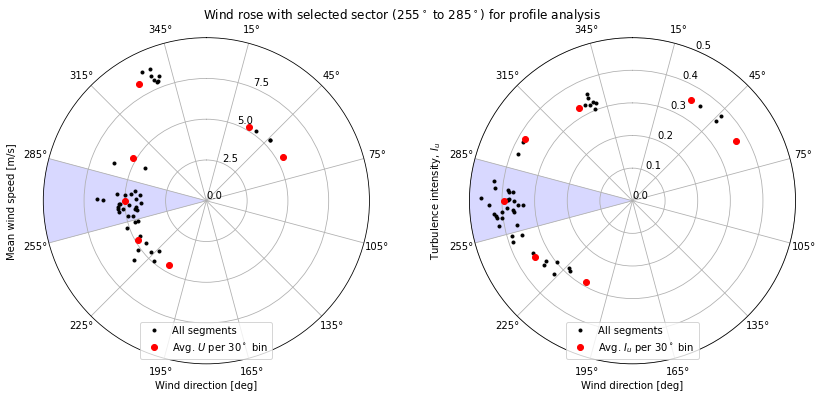

In [74]:

# Example data (wind directions in degrees, and wind speeds in m/s)
aoa = fieldData['AoA']
U = fieldData['U_orig']


# plt.polar(np.radians(fieldData['AoA']), fieldData['U'], 'k.')
# # set the limits
# # plt.ylim(0, 1.5)

# plt.plot(fieldData['AoA'],'.k')

# divide AoA into 16 bins
nBins = 12
binEdges = np.linspace(15,375,nBins+1)
binCenters = (binEdges[1:] + binEdges[:-1])/2
binWidth = binEdges[1] - binEdges[0]
binCounts = np.zeros(nBins)
binCounts_weighted = np.zeros(nBins)
binIndices = np.zeros(len(aoa), dtype=int)
for i in range(nBins):
    idx = np.where((aoa >= binEdges[i]) & (aoa < binEdges[i+1]))[0]
    binCounts[i] = len(idx)
    binCounts_weighted[i] = np.sum(U[idx])
    binIndices[idx] = i
binCounts = binCounts/np.sum(binCounts)*100
binCounts_weighted = binCounts_weighted/np.sum(binCounts_weighted)*100

# # plot the histogram
# fig, axs = plt.subplots(1,1,figsize=[13,6], subplot_kw={'projection': 'polar'})
# ax = axs
# ax.bar(np.radians(binCenters), binCounts_weighted, width=np.radians(binWidth), color='b', edgecolor='k', alpha=0.5, linewidth=2.0)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)
# # ax.set_ylim([0,60])
# ax.set_xticks(np.radians(np.arange(15,346,30)))
# # ax.set_yticks(np.arange(0,61,10))
# ax.set_xlabel('Wind direction [deg]')
# ax.set_title('Frequency [%]')
# ax.yaxis.set_label_coords(-0.08,0.5)
# ax.grid(True)

# plot the mean wind speed per bin
binSpeeds = np.zeros(nBins)
bin_Iu = np.zeros(nBins)
bin_Iv = np.zeros(nBins)
bin_Iw = np.zeros(nBins)

for i in range(nBins):
    idx = np.where(binIndices == i)[0]
    binSpeeds[i] = np.mean(U[idx]) if len(idx) > 0 else np.nan
    bin_Iu[i] = np.mean(fieldData['Iu'][idx]) if len(idx) > 0 else np.nan
    bin_Iv[i] = np.mean(fieldData['Iv'][idx]) if len(idx) > 0 else np.nan
    bin_Iw[i] = np.mean(fieldData['Iw'][idx]) if len(idx) > 0 else np.nan

fig, axs = plt.subplots(1,2,figsize=[14,6], subplot_kw={'projection': 'polar'})
ax = axs[0]  # mean wind speed
ax.bar(np.radians(270), 20, width=np.radians(30), color=[0.5,0.5,1], edgecolor='k', alpha=0.3, linewidth=0.1)
ax.plot(np.radians(fieldData['AoA']), fieldData['U_orig'], '.', color='k', linewidth=2.0, label='All segments')
ax.plot(np.radians(binCenters), binSpeeds, 'ro', linewidth=4.0, label=r'Avg. $U$ per $30^\circ$ bin')
ax.legend(loc='lower center' )
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0,10])
ax.set_xticks(np.radians(np.arange(15,346,30)))
ax.set_yticks(np.arange(0,10,2.5))
ax.yaxis.set_label_coords(-0.08,0.5)
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel('Mean wind speed [m/s]')
ax.set_title(r'Wind rose with selected sector ($255^\circ$ to $285^\circ$) for profile analysis')
# move location of title to top center of the full figure
ttl = ax.title
ttl.set_position([1.1, 1.1])


ax.grid(True)
# move the y-axis label away from the plot

ax = axs[1]  # Turbulence intensity, Iu
ax.bar(np.radians(270), 20, width=np.radians(30), color=[0.5,0.5,1], edgecolor='k', alpha=0.3, linewidth=0.1)
ax.plot(np.radians(fieldData['AoA']), fieldData['Iu'], '.', color='k', linewidth=2.0, label='All segments')
ax.plot(np.radians(binCenters), bin_Iu, 'ro', linewidth=4.0, label=r'Avg. $I_u$ per $30^\circ$ bin')
ax.legend(loc='lower center')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0,0.5])
ax.set_xticks(np.radians(np.arange(15,346,30)))
ax.set_yticks(np.arange(0,0.51,0.1))
ax.yaxis.set_label_coords(-0.08,0.5)
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel('Turbulence intensity, $I_u$')
# ax.set_title(r'Turbulence intensity ($255^\circ$ to $285^\circ$)')
ax.grid(True)

if saveFigs:
    fig.savefig(figDir+"windRose.svg",format='svg',dpi=1200, bbox_inches='tight')
    print('Figure saved as '+figDir+"windRose.svg")


### Pressure
#### $C_p$ contours

Figure saved to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/CpContour.svg


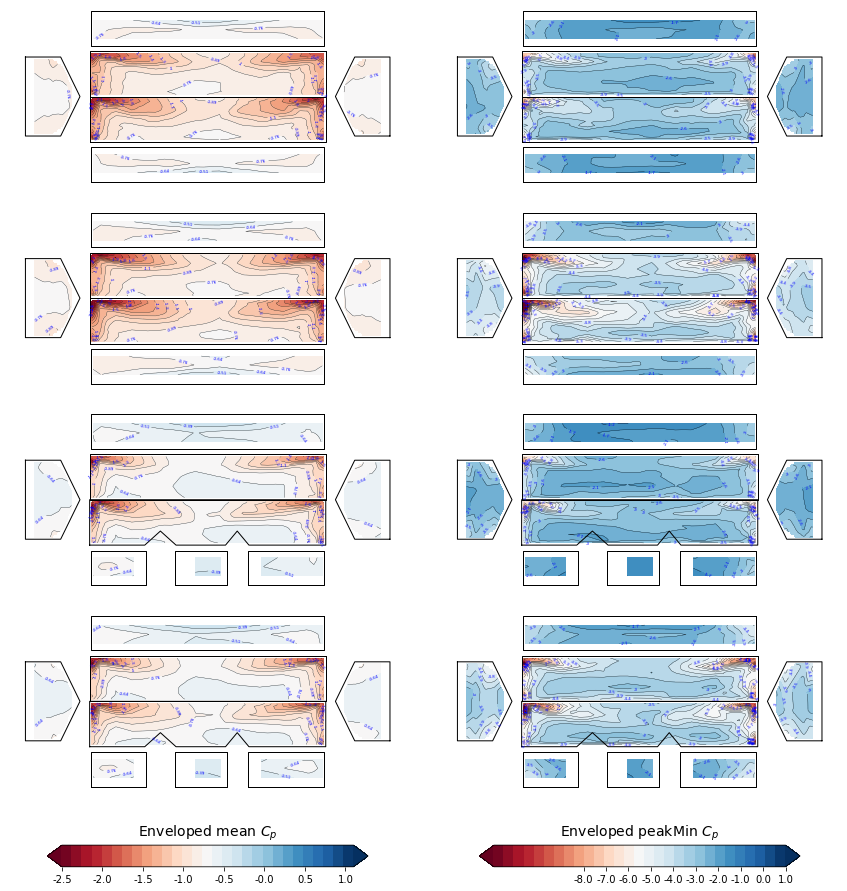

In [28]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(5,2,figsize=[12,14])
ax_cbar1 = axs[4,0]
ax_cbar2 = axs[4,1]
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for i, cp in enumerate([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU]):

    # fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    if i == 3:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar1.set_position(new_pos)

    fld, fldrange, ticks = 'peakMin', [-12., 1.], np.linspace(-8,1.0,10)

    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    if i == 3:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar2.set_position(new_pos)
# if saveFigs:
#     fileName = figDir+f"CpContour.svg"
#     fig.savefig(fileName,format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {fileName}")
    

#### $C_p$ vs. AoA per tap

uStar = 0.6405630880806761 m/s
z0 = 3.7279725615091376e-05 m

           Z          U      U_fit
0   0.009906   8.735224   8.939773
1   0.020066   9.670554  10.070184
2   0.029972  10.355544  10.712728
3   0.039878  11.137944  11.170028
4   0.050038  11.555158  11.533480
5   0.059944  11.863680  11.822739
6   0.070104  12.217777  12.073470
7   0.074930  12.350244  12.180083
8   0.080010  12.542555  12.285131
9   0.085090  12.444360  12.383710
10  0.089916  12.719682  12.472054
11  0.100076  12.814467  12.643491
12  0.109982  13.020620  12.794643
13  0.119888  13.149053  12.932750
14  0.130048  13.196008  13.063018
15  0.139954  13.289334  13.180578
16  0.149860  13.543192  13.290094
17  0.180086  13.692600  13.584326
18  0.210058  13.784487  13.830861
19  0.240030  14.129784  14.044457
20  0.270002  14.177212  14.232887
21  0.299974  14.277091  14.401462
22  0.329946  14.473783  14.553969
23  0.359918  14.493271  14.693207
24  0.389890  14.742340  14.821301
25  0.420116  14.840419  14.

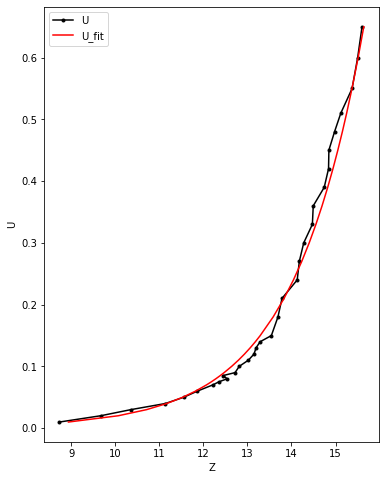

In [67]:
# df = windCodes.CpConversionFactor(from_='simulated', to_='NBCC', from_Z=[5, 8, 10, 30, 100], from_gustDuration=3600, from_z0=0.4)
# print(df)

z = vel_OP.Z[:-40]
U = vel_OP.U[:-40]

z0, uStar, U_fit = wind.fitVelDataToLogProfile(z, U, Zref=0.08, debugMode=True)

here


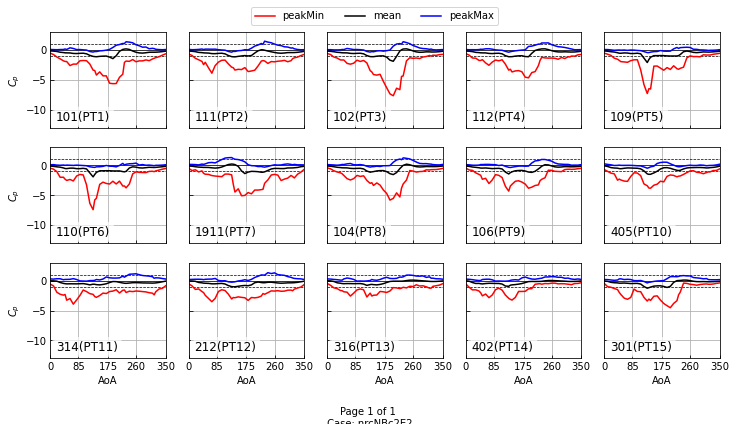

In [75]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
figs, all_axes = cp_iso_OP.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
                # xticks=np.linspace(0,360,5),
                pageNo_xy=(0.5,0.04),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
                legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# cp_iso_SU.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
#                 legend_bbox_to_anchor=(0.5, 0.95), figs=figs, all_axes=all_axes)#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


#### C&C pressure coefficients from codes

In [94]:
# val = wind.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a')
# # print(json.dumps(val, indent=4))

# print(wind.getDurstFactor(3.0)**2)


# cp_iso_OP.plotPanelCpStatContour(fieldName='mean')



35.97122


In [96]:
directionalityFactor = 1.0 #0.85
fig, axs = cp_iso_OP.plotCandC_load(figSize=[12.5,10], sharex=False, sharey=False,
                                    plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                                    xLimits=[0.1,100], yLimits=[-18,5],
                                    CandCLoadFormat='NBCC',
                                    yLabel=r"$C_pC_g$",
                                    label_min=r"BLWT", label_max=None,
                                    kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    overlayThese=[windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),  windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a')],
                                    overlayFactors=[1.0/directionalityFactor,                           (windCodes.getDurstFactor(3.0))**2],
                                    kwargs_overlay=({'color':'r',}, {'color':'k', 'linestyle':'--'}),
                                    legend_ax_idx=5,
                                    kwargs_legend={'loc':'center', 'fontsize':12},
                                    subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.03,0.94],
                                    kwargs_ax={'gridMinor':True},
                                    insetBounds=[0.05,0.0,0.9,0.4],
                                    zoneShadeColor='k',
                                    )

# if saveFigs:
#     fig.savefig(figDir+"CandC_Fig_E_iso.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")

fig, axs = cp_sur_OP.plotCandC_load(figSize=[12.5,10], sharex=False, sharey=False,
                                    plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                                    xLimits=[0.1,100], yLimits=[-18,5],
                                    CandCLoadFormat='NBCC',
                                    yLabel=r"$C_pC_g$",
                                    label_min=r"BLWT", label_max=None,
                                    kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    overlayThese=[windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),  windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a')],
                                    overlayFactors=[1.0/directionalityFactor,                           (windCodes.getDurstFactor(3.0))**2],
                                    kwargs_overlay=({'color':'r',}, {'color':'k', 'linestyle':'--'}),
                                    legend_ax_idx=5,
                                    kwargs_legend={'loc':'center', 'fontsize':12},
                                    subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.03,0.94],
                                    kwargs_ax={'gridMinor':True},
                                    insetBounds=[0.05,0.0,0.9,0.4],
                                    zoneShadeColor='k',
                                    )
# if saveFigs:
#     fig.savefig(figDir+"CandC_Fig_E_sur.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Saved figure: {figDir}CandC_Fig_E_sur.svg")


TypeError: 'bool' object is not iterable